# Pneumonia Detection from Chest X-rays
By Donna R -  25DLS145

### Loading the Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


### Imports

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

### Data Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train', target_size=(224, 224),
    batch_size=32, class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/val', target_size=(224, 224),
    batch_size=32, class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test', target_size=(224, 224),
    batch_size=32, class_mode='binary', shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Class Distribution

Class mapping (label -> index): {'NORMAL': 0, 'PNEUMONIA': 1}
Class 'NORMAL' has 1341 images.
Class 'PNEUMONIA' has 3875 images.


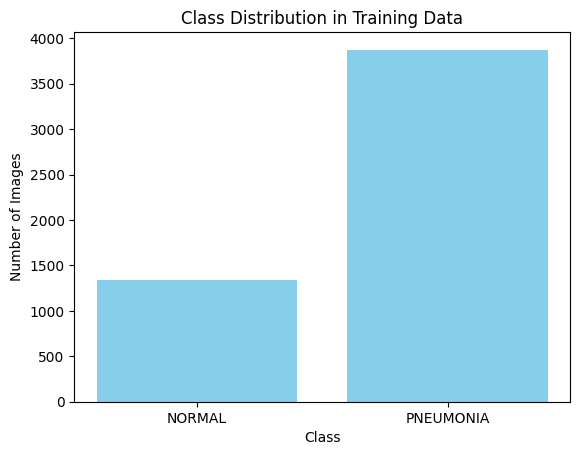

In [23]:
class_labels = train_generator.class_indices
print("Class mapping (label -> index):", class_labels)

idx_to_class = {v: k for k, v in class_labels.items()}

unique, counts = np.unique(train_generator.classes, return_counts=True)

for idx, count in zip(unique, counts):
    print(f"Class '{idx_to_class[idx]}' has {count} images.")

plt.bar([idx_to_class[i] for i in unique], counts, color='skyblue')
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

### Modelling
Trial with 2 different models

#### CNN

In [6]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer= optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=val_generator, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 554s 3s/step - accuracy: 0.7489 - loss: 0.5287 - val_accuracy: 0.6875 - val_loss: 0.5172
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 546s 3s/step - accuracy: 0.8903 - loss: 0.2584 - val_accuracy: 0.7500 - val_loss: 0.5168
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - accuracy: 0.9132 - loss: 0.2228 - val_accuracy: 0.6250 - val_loss: 0.8321
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.9140 - loss: 0.2165 - val_accuracy: 0.8125 - val_loss: 0.3689
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 535s 3s/step - accuracy: 0.9210 - loss: 0.2069 - val_accuracy: 0.6875 - val_loss: 0.5834
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 534s 3s/step - accuracy: 0.9204 - loss: 0.1989 - val_accuracy: 0.6875 - val_loss: 0.6378
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - accuracy: 0.9285 - loss: 0.1842 - val_accuracy: 0.7500 - val_loss: 0.4295
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 545s 3s/step - accuracy: 0.9314 - loss: 0.1809 - val_accu

In [7]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 963ms/step - accuracy: 0.7918 - loss: 0.5085
Test Accuracy: 0.86


#### Transfer Learning

In [8]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=val_generator, epochs=5)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.8336 - loss: 0.3497 - val_accuracy: 0.8750 - val_loss: 0.3511
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.9389 - loss: 0.1606 - val_accuracy: 0.9375 - val_loss: 0.3102
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.9502 - loss: 0.1312 - val_accuracy: 0.8750 - val_loss: 0.2743
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.9559 - loss: 0.1166 - val_accuracy: 0.9375 - val_loss: 0.2611
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9548 - loss: 0.1173 - val_accuracy: 0.9375 - val_loss: 0.2471


In [10]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8250 - loss: 0.3732
Test Accuracy: 0.88


### Evaluation

#### Confusion Matrix and Classification

In [9]:
import numpy as np
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
[[173  61]
 [ 14 376]]
              precision    recall  f1-score   support

      NORMAL       0.93      0.74      0.82       234
   PNEUMONIA       0.86      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.87       624
weighted avg       0.88      0.88      0.88       624



#### Correct and Incorrect Predictions

In [12]:
pred_probs = model.predict(test_generator)
y_pred = (pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes

file_paths = test_generator.filepaths

correct = np.where(y_pred == y_true)[0]
incorrect = np.where(y_pred != y_true)[0]

20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step


In [17]:
print("Total correct predictions: ", len(correct))
print("Total incorrect predictions: ", len(incorrect))

Total correct predictions:  549
Total incorrect predictions:  75


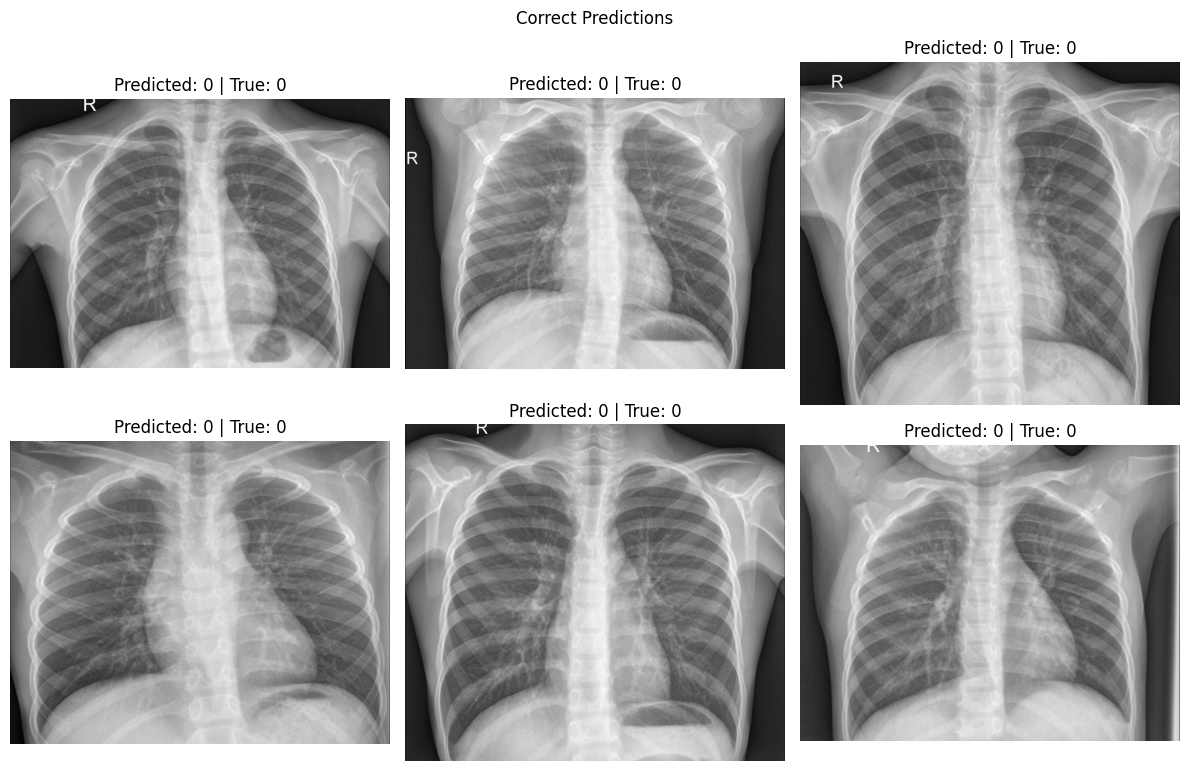

In [20]:
plt.figure(figsize=(12, 8))
for i, idx in enumerate(correct[:6]):
    img = plt.imread(file_paths[idx])
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {y_pred[idx]} | True: {y_true[idx]}")
    plt.axis('off')
plt.suptitle("Correct Predictions")
plt.tight_layout()
plt.show()

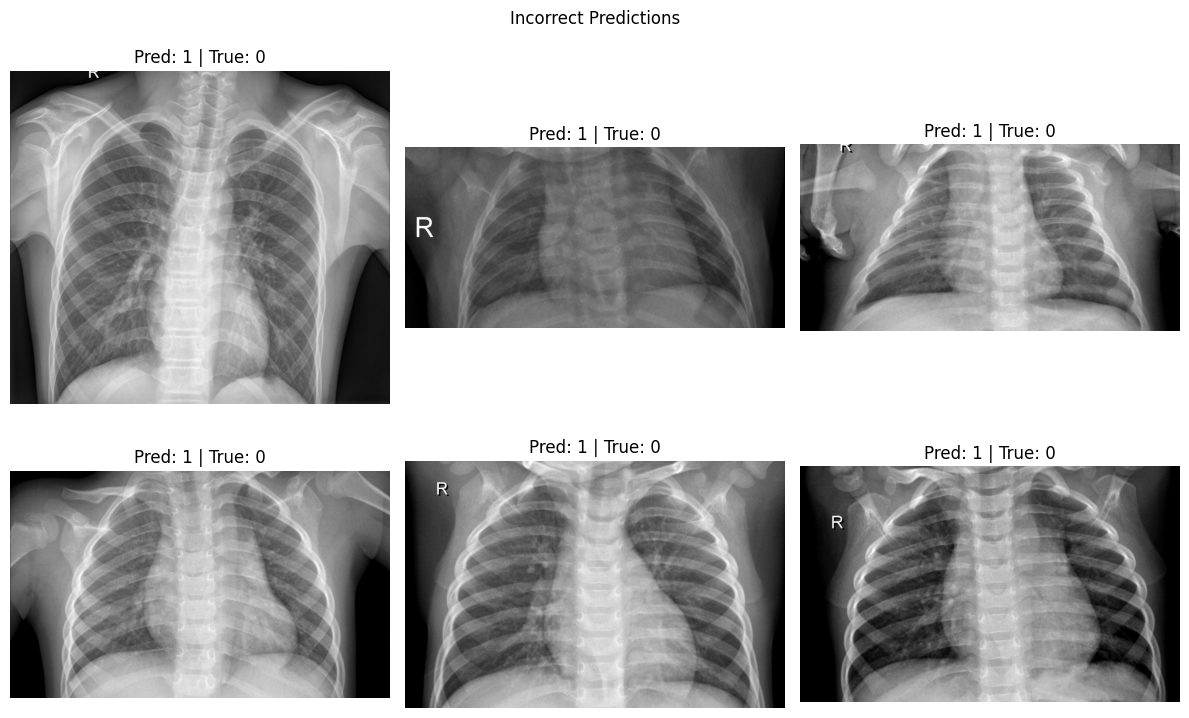

In [14]:
plt.figure(figsize=(12, 8))
for i, idx in enumerate(incorrect[:6]):
    img = plt.imread(file_paths[idx])
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {y_pred[idx]} | True: {y_true[idx]}")
    plt.axis('off')
plt.suptitle("Incorrect Predictions")
plt.tight_layout()
plt.show()

### Saving the model

In [21]:
model.save("pneumonia_detection.h5")